# Example on INFN analysis facility with systematic variations
Here we are going to perform  of the VBS with a lepton and a tau as final state reconstruction on an OpenData sample of W+Jets events.


## Basic imports and definitions of number of parallel tasks and the Dask scheduler port

In [1]:
import ROOT
import os
from dask.distributed import Client

nmaxpartitions = 50
sched_port = 25136

Welcome to JupyROOT 6.27/01


## Declare custom functions defined in utils.h

In [2]:
text_file = open("utils.h", "r")
data = text_file.read()


def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))

client = Client(address="tcp://127.0.0.1:"+str(sched_port))
ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

/usr/local/lib/python3.8/dist-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.3  | 1.0.2     | 1.0.3   |
| toolz   | 0.11.2 | 0.11.1    | 0.11.2  |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Define chain of rootfiles to analyze

In [3]:
chain = [
         #"root://eospublic.cern.ch//eos/root-eos/benchmark/CMSOpenDataHiggsTauTau/W1JetsToLNu.root",
         "root://eospublic.cern.ch//eos/root-eos/benchmark/CMSOpenDataHiggsTauTau/W2JetsToLNu.root",
         "root://eospublic.cern.ch//eos/root-eos/benchmark/CMSOpenDataHiggsTauTau/W3JetsToLNu.root",
        ]

## Do analysis

In [4]:
df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame("Events", chain, npartitions=nmaxpartitions, daskclient=client)   

df_varied = df.Vary("Muon_pt", "ROOT::VecOps::RVec<ROOT::VecOps::RVec<float>>{Muon_pt*0.8, Muon_pt*1.2}", variationTags=["down", "up"], variationName="dummyVariation")

df_atleast2Jets = df_varied.Filter("nJet>=2", "At least two jets")
df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_eta, Jet_pt, Jet_puId)")
df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")
df_jetsDefinitions = df_2VBSjets.Define("leadjet_pt", "Jet_pt[VBSJet_idx[0]]")\
                                .Define("leadjet_eta", "Jet_eta[VBSJet_idx[0]]")\
                                .Define("leadjet_phi", "Jet_phi[VBSJet_idx[0]]")\
                                .Define("leadjet_mass", "Jet_mass[VBSJet_idx[0]]")\
                                .Define("subleadjet_pt", "Jet_pt[VBSJet_idx[1]]")\
                                .Define("subleadjet_eta", "Jet_eta[VBSJet_idx[1]]")\
                                .Define("subleadjet_phi", "Jet_phi[VBSJet_idx[1]]")\
                                .Define("subleadjet_mass", "Jet_mass[VBSJet_idx[1]]")\

df_selectMuon = df_jetsDefinitions.Define("Muon_idx", "SelectMuon(Muon_pt, Muon_eta, Muon_phi, Jet_eta, Jet_phi, VBSJet_idx)")
df_compatibleLeptons = df_selectMuon.Filter("Muon_idx[1] != -1", "Filter on leptons")
df_leptonDefinitions = df_compatibleLeptons.Define("lepton_pt", "Muon_pt[Muon_idx[0]]")\
                                           .Define("lepton_eta", "Muon_eta[Muon_idx[0]]")\
                                           .Define("lepton_phi", " Muon_phi[Muon_idx[0]]")\
                                           .Define("lepton_mass", "Muon_mass[Muon_idx[0]]")\

df_selectTau = df_leptonDefinitions.Define("Tau_idx", "SelectAndVetoTaus(Tau_pt, Tau_eta, Tau_phi, Muon_idx, Muon_eta, Muon_phi, Jet_eta, Jet_phi, VBSJet_idx)")
df_1tau = df_selectTau.Filter("Tau_idx[1] != -1", "Exactly 1 Tau")
df_tauDefinitions = df_1tau.Define("tau_pt", "Tau_pt[Tau_idx[0]]")\
                           .Define("tau_eta", "Tau_eta[Tau_idx[0]]")\
                           .Define("tau_phi", "Tau_phi[Tau_idx[0]]")\
                           .Define("tau_mass", "Tau_mass[Tau_idx[0]]")\

df_selection = df_tauDefinitions.Define("m_jjtaulep","GetInvMass(leadjet_pt, leadjet_eta, leadjet_phi, leadjet_mass, subleadjet_pt, subleadjet_eta, subleadjet_phi, subleadjet_mass, tau_pt, tau_eta, tau_phi, tau_mass, lepton_pt, lepton_eta, lepton_phi, lepton_mass)")

h = df_selection.Histo1D(("m_jjtaulep", "" , 10, 0, 3000), "m_jjtaulep")

## Do systematic variations

In [5]:
h_varied = ROOT.RDF.Experimental.Distributed.VariationsFor(h)

## Draw nominal and varied histos
N.B. no proper event weighting here, just for example purposes

CPU times: user 2.52 s, sys: 360 ms, total: 2.88 s
Wall time: 1min 44s


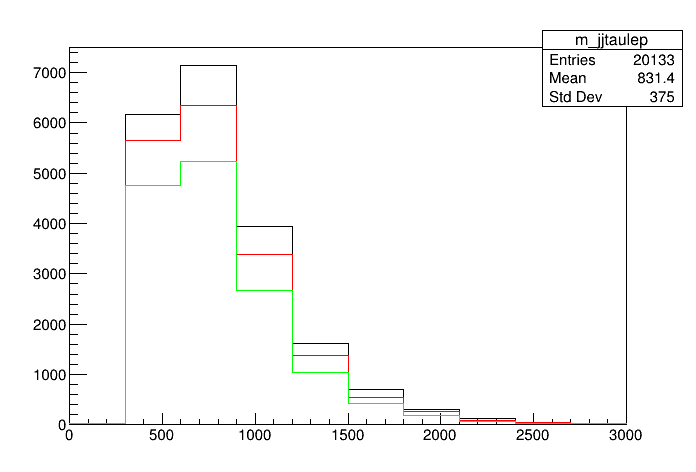

In [6]:
%%time
c = ROOT.TCanvas()
h_varied["dummyVariation:up"].SetLineColor(1)
h_varied["dummyVariation:up"].Draw()
h_varied["nominal"].SetLineColor(2)
h_varied["nominal"].Draw('SAME')
h_varied["dummyVariation:down"].SetLineColor(3)
h_varied["dummyVariation:down"].Draw('SAME')
c.Draw()